In [1]:
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
import mne
from pprint import pprint
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [11]:
data_path = '/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/'

cntFile = data_path + 'S007_Alice_S001_new_2nd.cnt' #'S001_Alice.cnt'  
'''
S001_Alice.cnt: 最外圈的（編號尾數7的）沒有很毛，所以不exclude
'''

raw = mne.io.read_raw_cnt(cntFile)
raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])

Reading 0 ... 942719  =      0.000 ...   942.719 secs...


<ipython-input-11-9cc5a91129c0>:8: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cntFile)


<Info | 9 non-empty values
 bads: 1 items (Audio)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 67 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio']


In [6]:
# List out the triggers
events = mne.events_from_annotations(raw)
#print(events)
#print(events[1])
print(events[0])   # the starting and ending time point for each tape #時間要除以1000=事件發生的時間點
print(len(events[0]))

print(type(events[0]))
print(events[1])
tape_durLIST = 

triggersNDARRAY = events[0]
#print(range(triggersNDARRAY[0], triggersNDARRAY[-1], 2))

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
[[ 26289      0      1]
 [ 84300      0     25]
 [ 84811      0      9]
 [101884      0     25]
 [102954      0      5]
 [163965      0     25]
 [164475      0     10]
 [174750      0     25]
 [178931      0      6]
 [242943      0     25]
 [243453      0     11]
 [258434      0     25]
 [259980      0      7]
 [329992      0     25]
 [330503      0     12]
 [338150      0     25]
 [339669      0      8]
 [406680      0     25]
 [407190      0     13]
 [422467      0     25]
 [423993      0     19]
 [488004      0     25]
 [488514      0     14]
 [502584      0     25]
 [504082      0     22]
 [567094      0     25]
 [567604      0     15]
 [573317      0     25]
 [574824      0     23]
 [632835      0     25]
 [633345      0     16]
 [641884      0     25]
 [643401      0     24]
 [701413      0     25]
 [701924   

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


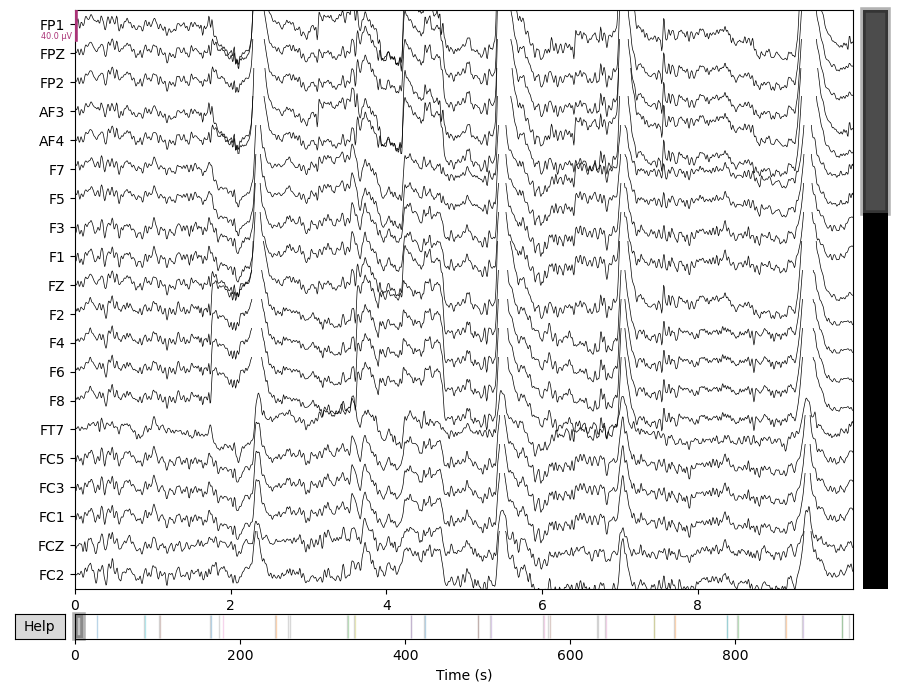

Channels marked as bad: none
Channels marked as bad: ['Audio']


In [12]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq = 250)
n_raw.filter(0.1, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg = True, stim = False, exclude = ['M1', 'M2', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
n_raw.plot()

# remove dc-offset

In [8]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

# Exclude certain components
"""
S001:[0,5]  # DONE
S002:[0, 1, 3, 8, 10] #DONE
S003:[0,8,14] # DONE
S004-2:[0, 1, 3, 4, 6] #DONE
S005:[0, 1, 2, 8] #DONE
S006:[] #WEIRD!!!
S007:[] #WEIRD!!!
"""

#ica_.plot_sources(n_raw)
#ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_raw, exclude=[0,8,14])

Fitting ICA to data using 57 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.5s.


'\nS001:[0,5]  # DONE\nS002:[0, 1, 3, 8, 10] #DONE\nS003:[0,8,14] # DONE\nS004-2:[0, 1, 3, 4, 6] #DONE\nS005:[0, 1, 2, 8] #DONE\nS006:[] #WEIRD!!!\nS007:[] #WEIRD!!!\n'

In [10]:
for i in range(15):
    ica_.plot_properties(n_raw, picks=[i])
    #ica_.plot_overlay(n_raw, exclude=[i])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
471 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
471 matching events found
No baseline correction applied


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 7 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing o

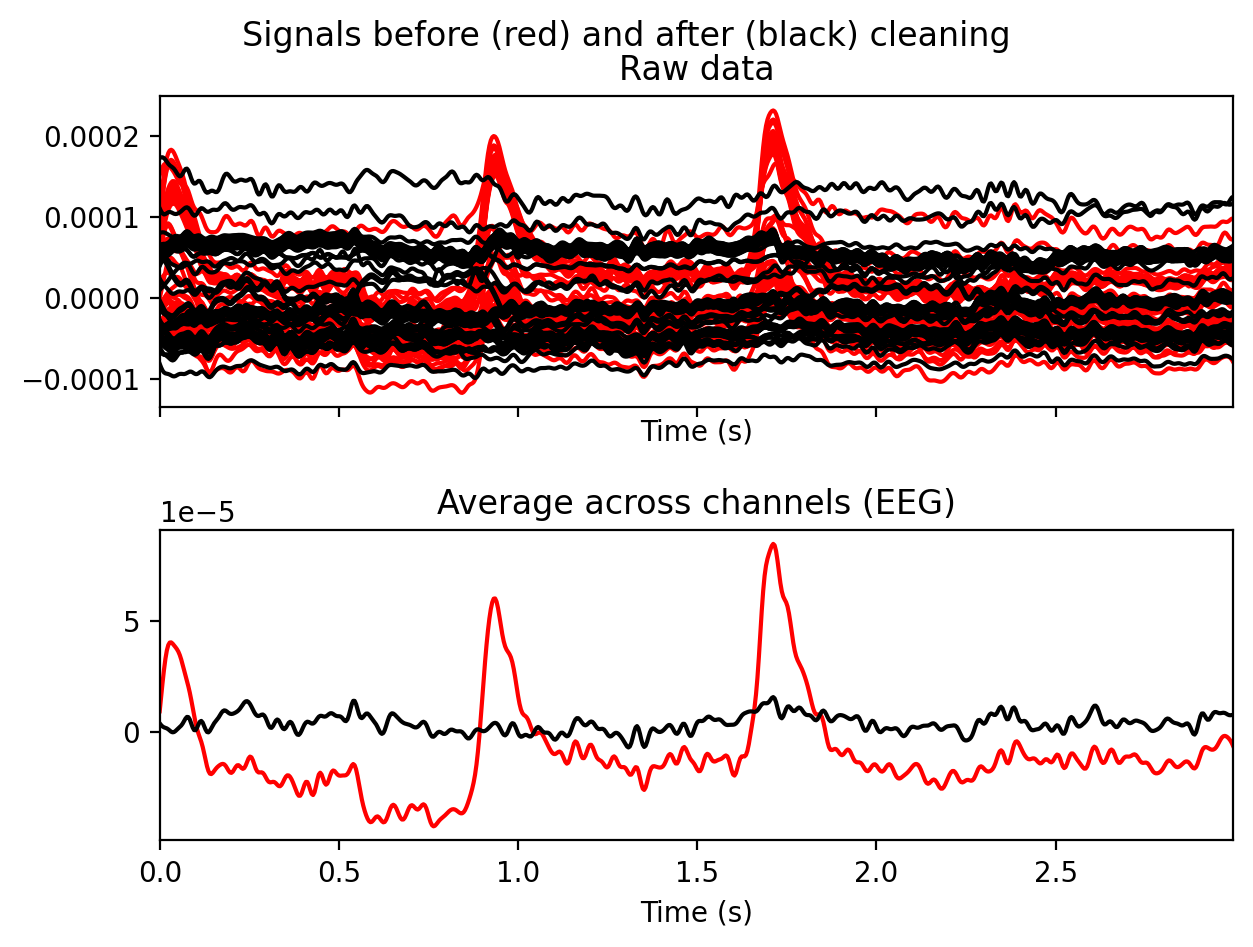

In [21]:
ica_.plot_overlay(n_raw, exclude=[0,1,2,3,5,7,10,11])
ica_.plot_overlay(n_raw, exclude=[0,1,2,3,5,7,10])
ica_.plot_overlay(n_raw, exclude=[0,1,2,3,5,7])
ica_.plot_overlay(n_raw, exclude=[0,1,2,3,5])
ica_.plot_overlay(n_raw, exclude=[0,1,2,3])
ica_.plot_overlay(n_raw, exclude=[0,1,2])
ica_.plot_overlay(n_raw, exclude=[0,1])

In [23]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
ica_.exclude = [0,5]

raw_clean = n_raw.copy()
ica_.apply(raw_clean)
raw_clean.plot()


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components
Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


In [40]:
def correct_time(Start_timeFLOAT, End_timeFLOAT, stim_onsetFLOAT):
    actual_timeFLOAT = stim_onsetFLOAT*(End_timeFLOAT-Start_timeFLOAT)+(Start_timeFLOAT)
    return actual_timeFLOAT

In [6]:
# List out the triggers
events_clean = mne.events_from_annotations(raw)
print(events_clean[0])   # the starting and ending time point for each tape #時間要除以1000=事件發生的時間點
print(len(events_clean[0]))

print(type(events_clean[0]))
print(events_clean[1])


#triggersNDARRAY = events_clean[0]

Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '7', '8', '9', '99']
[[ 26289      0      1]
 [ 84300      0     25]
 [ 84811      0      9]
 [101884      0     25]
 [102954      0      5]
 [163965      0     25]
 [164475      0     10]
 [174750      0     25]
 [178931      0      6]
 [242943      0     25]
 [243453      0     11]
 [258434      0     25]
 [259980      0      7]
 [329992      0     25]
 [330503      0     12]
 [338150      0     25]
 [339669      0      8]
 [406680      0     25]
 [407190      0     13]
 [422467      0     25]
 [423993      0     19]
 [488004      0     25]
 [488514      0     14]
 [502584      0     25]
 [504082      0     22]
 [567094      0     25]
 [567604      0     15]
 [573317      0     25]
 [574824      0     23]
 [632835      0     25]
 [633345      0     16]
 [641884      0     25]
 [643401      0     24]
 [701413      0     25]
 [701924   

In [7]:
csv_data_path = "/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice(EEG dataset and stimuli)/"

with open(csv_data_path + 'AliceChapterOne-EEG.csv', "r", encoding="UTF-8") as raw_file:
    fileLIST = raw_file.read().split("\n")
    fileLIST.pop(0)
    #pprint(fileLIST[0])
#'Word,Segment,onset,offset,Order,LogFreq,LogFreq_Prev,LogFreq_Next,SndPower,Length,Position,Sentence,IsLexical,NGRAM,RNN,CFG'
    
onset_timeLIST = []

# collect all the onset time into one LIST >> perhaps into 12 LISTs would be better??
for row in fileLIST:
    rowLIST = row.split(",")
    #print(rowLIST)
    print(rowLIST[1]) # segment = tape
    print(rowLIST[2])
    print(type(rowLIST[2]))
    onset_timeFloat = round(float(rowLIST[2]), 4)
    print(onset_timeFloat)
    #onset_timeLIST.append(onset_timeFloat) 
#pprint(onset_timeLIST)
#print(len(onset_timeLIST))

1
0.0459999999999994
<class 'str'>
0.046
1
0.562721
<class 'str'>
0.5627
1
0.784543
<class 'str'>
0.7845
1
1.256929
<class 'str'>
1.2569
1
1.352925
<class 'str'>
1.3529
1
1.616327
<class 'str'>
1.6163
1
2.310749
<class 'str'>
2.3107
1
2.799918
<class 'str'>
2.7999
1
2.938712
<class 'str'>
2.9387
1
3.30449
<class 'str'>
3.3045
1
3.484082
<class 'str'>
3.4841
1
3.654596
<class 'str'>
3.6546
1
4.106667
<class 'str'>
4.1067
1
4.274286
<class 'str'>
4.2743
1
4.398799
<class 'str'>
4.3988
1
4.785961
<class 'str'>
4.786
1
4.908844
<class 'str'>
4.9088
1
5.034329
<class 'str'>
5.0343
1
5.435647
<class 'str'>
5.4356
1
5.890613
<class 'str'>
5.8906
1
6.051306
<class 'str'>
6.0513
1
7.147755
<class 'str'>
7.1478
1
7.380186
<class 'str'>
7.3802
1
7.4995
<class 'str'>
7.4995
1
7.957925
<class 'str'>
7.9579
1
8.261225
<class 'str'>
8.2612
1
8.560545
<class 'str'>
8.5605
1
8.776055
<class 'str'>
8.7761
1
8.88381
<class 'str'>
8.8838
1
9.231021
<class 'str'>
9.231
1
9.31483
<class 'str'>
9.3148
1
9.70

40.55633779
<class 'str'>
40.5563
3
41.02327679
<class 'str'>
41.0233
3
41.27470579
<class 'str'>
41.2747
3
42.67552179
<class 'str'>
42.6755
3
43.00499679
<class 'str'>
43.005
3
43.52558979
<class 'str'>
43.5256
3
43.66323679
<class 'str'>
43.6632
3
43.76783279
<class 'str'>
43.7678
3
43.95661079
<class 'str'>
43.9566
3
44.25592979
<class 'str'>
44.2559
3
44.37565779
<class 'str'>
44.3757
3
44.51420779
<class 'str'>
44.5142
3
45.42502979
<class 'str'>
45.425
3
45.72658979
<class 'str'>
45.7266
3
45.81239279
<class 'str'>
45.8124
3
46.00234879
<class 'str'>
46.0023
3
46.11171279
<class 'str'>
46.1117
3
46.32722279
<class 'str'>
46.3272
3
46.81303279
<class 'str'>
46.813
3
47.10374579
<class 'str'>
47.1037
3
47.24876179
<class 'str'>
47.2488
3
47.52689079
<class 'str'>
47.5269
3
47.68014779
<class 'str'>
47.6801
3
47.82382079
<class 'str'>
47.8238
3
48.07625279
<class 'str'>
48.0763
3
48.25484179
<class 'str'>
48.2548
3
48.36628679
<class 'str'>
48.3663
3
48.66191679
<class 'str'>
48.66

5
34.74727017
<class 'str'>
34.7473
5
35.16631717
<class 'str'>
35.1663
5
35.25538517
<class 'str'>
35.2554
5
36.35162417
<class 'str'>
36.3516
5
36.51924317
<class 'str'>
36.5192
5
36.62699817
<class 'str'>
36.627
5
37.15380017
<class 'str'>
37.1538
5
37.40522917
<class 'str'>
37.4052
5
37.79375817
<class 'str'>
37.7938
5
37.86302017
<class 'str'>
37.863
5
39.51244017
<class 'str'>
39.5124
5
39.71597717
<class 'str'>
39.716
5
39.96740617
<class 'str'>
39.9674
5
40.43434517
<class 'str'>
40.4343
5
40.82944717
<class 'str'>
40.8294
5
40.94917517
<class 'str'>
40.9492
5
41.15271217
<class 'str'>
41.1527
5
41.40025117
<class 'str'>
41.4003
5
42.38590917
<class 'str'>
42.3859
5
42.55092317
<class 'str'>
42.5509
5
42.81693017
<class 'str'>
42.8169
5
43.00849417
<class 'str'>
43.0085
5
43.42754217
<class 'str'>
43.4275
5
43.58318817
<class 'str'>
43.5832
5
44.13393617
<class 'str'>
44.1339
5
44.21774617
<class 'str'>
44.2177
5
44.27761017
<class 'str'>
44.2776
5
44.64876617
<class 'str'>
44.

7
29.14796819
<class 'str'>
29.148
7
29.28449919
<class 'str'>
29.2845
7
29.37540519
<class 'str'>
29.3754
7
29.71068919
<class 'str'>
29.7107
7
30.23749119
<class 'str'>
30.2375
7
30.57369419
<class 'str'>
30.5737
7
31.08755919
<class 'str'>
31.0876
7
31.47068919
<class 'str'>
31.4707
7
32.57218519
<class 'str'>
32.5722
7
32.77572319
<class 'str'>
32.7757
7
33.15885219
<class 'str'>
33.1589
7
33.24266119
<class 'str'>
33.2427
7
33.56592719
<class 'str'>
33.5659
7
33.94905619
<class 'str'>
33.9491
7
34.20832419
<class 'str'>
34.2083
7
34.32021319
<class 'str'>
34.3202
7
34.39204919
<class 'str'>
34.392
7
35.06252519
<class 'str'>
35.0625
7
35.24211719
<class 'str'>
35.2421
7
35.37381819
<class 'str'>
35.3738
7
35.55341019
<class 'str'>
35.5534
7
36.15204919
<class 'str'>
36.152
7
36.60701519
<class 'str'>
36.607
7
36.81055319
<class 'str'>
36.8106
7
38.83395419
<class 'str'>
38.834
7
39.28013419
<class 'str'>
39.2801
7
39.71994019
<class 'str'>
39.7199
7
39.80375019
<class 'str'>
39.80

34.2114
9
34.37905978
<class 'str'>
34.3791
9
34.78613478
<class 'str'>
34.7861
9
34.88191678
<class 'str'>
34.8819
9
36.83348178
<class 'str'>
36.8335
9
37.27647478
<class 'str'>
37.2765
9
37.53987678
<class 'str'>
37.5399
9
37.86314178
<class 'str'>
37.8631
9
38.05395178
<class 'str'>
38.054
9
38.40191678
<class 'str'>
38.4019
9
38.76524378
<class 'str'>
38.7652
9
39.51538678
<class 'str'>
39.5154
9
39.71759178
<class 'str'>
39.7176
9
40.16191678
<class 'str'>
40.1619
9
40.52110078
<class 'str'>
40.5211
9
40.62885578
<class 'str'>
40.6289
9
41.07184878
<class 'str'>
41.0718
9
41.65851578
<class 'str'>
41.6585
9
41.83810778
<class 'str'>
41.8381
9
42.28110078
<class 'str'>
42.2811
9
42.48463778
<class 'str'>
42.4846
9
42.92763178
<class 'str'>
42.9276
9
43.77769978
<class 'str'>
43.7777
9
43.92081278
<class 'str'>
43.9208
9
44.31647478
<class 'str'>
44.3165
9
44.49606678
<class 'str'>
44.4961
9
45.05878778
<class 'str'>
45.0588
9
45.12206978
<class 'str'>
45.1221
9
45.41779278
<class 

50.3162
11
50.44025927
<class 'str'>
50.4403
11
50.87127927
<class 'str'>
50.8713
11
50.94311627
<class 'str'>
50.9431
11
51.15862627
<class 'str'>
51.1586
11
51.42202827
<class 'str'>
51.422
11
51.84107527
<class 'str'>
51.8411
11
52.37985127
<class 'str'>
52.3799
11
52.51428327
<class 'str'>
52.5143
11
52.65522527
<class 'str'>
52.6552
11
53.05558027
<class 'str'>
53.0556
11
53.42148427
<class 'str'>
53.4215
11
53.64896727
<class 'str'>
53.649
11
53.79717427
<class 'str'>
53.7972
11
53.89024527
<class 'str'>
53.8902
11
54.21168827
<class 'str'>
54.2117
11
54.51732527
<class 'str'>
54.5173
11
55.33114927
<class 'str'>
55.3311
12
0.229476225
<class 'str'>
0.2295
12
0.504358225
<class 'str'>
0.5044
12
0.658032225
<class 'str'>
0.658
12
0.974924225
<class 'str'>
0.9749
12
1.266236225
<class 'str'>
1.2662
12
1.441863225
<class 'str'>
1.4419
12
1.515146225
<class 'str'>
1.5151
12
1.801046225
<class 'str'>
1.801
12
2.220094225
<class 'str'>
2.2201
12
2.687033225
<class 'str'>
2.687
12
2.794

IndexError: list index out of range

In [ ]:
# Use the event id >> should segment the data first??
event_id = {'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
#{'1': 1, '10': 2, '11': 3, '12': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '99': 13}
                                        # state which conditions match with which triggers #

# each epoch would be 300 ms long 
# >> start_timepoint = each onset, end_timepoint = onset + 0.3
# need to recalibrate the starting time point in every part of 
tmin = -0.5                                         # pre stimulis interval (in seconds) #
tmax = 1.0                                          # post stimulus interval #

picks = mne.pick_types(raw_.info, eeg= True, stim = False)    # channels to use in epochs #
baseline = (-0.1, 0)      
reject_ = dict(eeg=100e-6) # eeg: V, meg: T                                                       # what to use as baseline comparison - here it's pre-stim interval #
epochs = mne.Epochs(raw_clean, new_events, event_id, tmin, tmax, proj = True,
                    picks = picks, baseline=baseline,
                    reject = reject_, preload = True)

In [ ]:
std_evoked = epochs['Standard (yi3)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devL_evoked = epochs['Large deviant (yi1)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)
devS_evoked = epochs['Small deviant (yi2)'].average().apply_baseline((-0.1, 0)).pick_types(eeg= True, stim = False).crop(-0.1, 0.7)

print(std_evoked)
print(devL_evoked)
print(devS_evoked)

In [ ]:
tmp = [std_evoked, devL_evoked, devS_evoked]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')

In [116]:
# Cutting the data based on the trigger of that 
'''
print(events[0])
print(type(events[0]))
print(events[1])
print(type(events[1]))
'''
#print(events[0][0][0])
#print(events[0][0][2])
print(len(events[0]))

timeArrays = events[0]


timeLIST = []
for i in timeArrays:
    timePoints = i[0]
    markers = i[2]
    timeLIST.append(timePoints)
#print(timeLIST)
#print(timeLIST[0])

tmpLIST = []
n_timeLIST = []
for k in range(24):
    tmin = float(timeLIST[k])/1000
    tmax = float(timeLIST[k+1])/1000
    cut_file = raw.copy().crop(tmin = tmin, tmax= tmax)
    cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
print("ALL DONE!")

24
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_01_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_02_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_03_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_04_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_05_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif
[done]


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_06_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_07_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_08_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_09_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_010_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_011_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_012_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_013_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_014_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_015_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_016_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_017_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif
[done]


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_018_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_019_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_020_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_021_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif
[done]
Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif


<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_022_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif
<ipython-input-116-7989e7538c5c>:28: RuntimeWarning: This filename (/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  cut_file.save(data_path + 'S001_0{}_cut.fif'.format(k+1), overwrite = False)  #de002-1_F051prg003-1. normal_03-01_cut1.fif


Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results/EEG/S001_023_cut.fif
[done]


IndexError: list index out of range